In [41]:
# Import modules
import numpy as np
import pandas as pd
import nltk
import os
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.cluster.hierarchy import linkage, dendrogram

In [9]:
# Set seed for reproducibility
np.random.seed(5)

# Read in movie data 
movies_df = pd.read_csv(os.getcwd()+ '/movies.csv')

print("Number of movies loaded: %s " % (len(movies_df)))

# Display
movies_df

Number of movies loaded: 100 


,rank,title,genre,wiki_plot,imdb_plot
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1..."
...,...,...,...,...,...
95,95,Rebel Without a Cause,[u' Drama'],\n\n\n\nJim Stark is in police custody.\n\n \...,Shortly after moving to Los Angeles with his p...
96,96,Rear Window,"[u' Mystery', u' Thriller']",\n\n\n\nJames Stewart as L.B. Jefferies\n\n \...,"L.B. ""Jeff"" Jeffries (James Stewart) recuperat..."
97,97,The Third Man,"[u' Film-Noir', u' Mystery', u' Thriller']",\n\n\n\nSocial network mapping all major chara...,"Sights of Vienna, Austria, flash across the sc..."
98,98,North by Northwest,"[u' Mystery', u' Thriller']",Advertising executive Roger O. Thornhill is mi...,"At the end of an ordinary work day, advertisin..."


In [11]:
# Combine wiki_plot and imdb_plot into a single column
movies_df['plot'] = movies_df['wiki_plot'].astype(str) + "\n" + \
                 movies_df['imdb_plot'].astype(str)

movies_df.head()

,rank,title,genre,wiki_plot,imdb_plot,plot
0,0,The Godfather,"[u' Crime', u' Drama']","On the day of his only daughter's wedding, Vit...","In late summer 1945, guests are gathered for t...","On the day of his only daughter's wedding, Vit..."
1,1,The Shawshank Redemption,"[u' Crime', u' Drama']","In 1947, banker Andy Dufresne is convicted of ...","In 1947, Andy Dufresne (Tim Robbins), a banker...","In 1947, banker Andy Dufresne is convicted of ..."
2,2,Schindler's List,"[u' Biography', u' Drama', u' History']","In 1939, the Germans move Polish Jews into the...",The relocation of Polish Jews from surrounding...,"In 1939, the Germans move Polish Jews into the..."
3,3,Raging Bull,"[u' Biography', u' Drama', u' Sport']","In a brief scene in 1964, an aging, overweight...","The film opens in 1964, where an older and fat...","In a brief scene in 1964, an aging, overweight..."
4,4,Casablanca,"[u' Drama', u' Romance', u' War']",It is early December 1941. American expatriate...,"In the early years of World War II, December 1...",It is early December 1941. American expatriate...


In [17]:
# Tokenize a paragraph into sentences 
sentence_tokenized = []
for sentence in nltk.sent_tokenize("""
                        Today (May 19, 2016) is his only daughter's wedding. 
                        Vito Corleone is the Godfather.
                        """):
         sentence_tokenized.append(sentence)
        

# tokenize the first sentence from sentence_tokenized into words
words_tokenized = []
for word in nltk.word_tokenize(sentence_tokenized[0]) : 
    words_tokenized.append(word)

print(words_tokenized)

# Remove tokens that do not contain any letters 
filtered = []
for word in words_tokenized:
    if re.search('[a-zA-Z]', word):
        filtered.append(word)

# words after tokenization
filtered


['Today', '(', 'May', '19', ',', '2016', ')', 'is', 'his', 'only', 'daughter', "'s", 'wedding', '.']


['Today', 'May', 'is', 'his', 'only', 'daughter', "'s", 'wedding']

In [45]:
# stemming

# SnowballStemmer obj
stemmer = SnowballStemmer("english")

print("before stemming: ", filtered)

# Stem the words from filtered and store in stemmed_words
stemmed_words = []
for word in filtered: 
    stemmed_words.append(stemmer.stem(word))

print("After stemming:   ", stemmed_words)

before stemming:  ['Today', 'May', 'is', 'his', 'only', 'daughter', "'s", 'wedding']
After stemming:    ['today', 'may', 'is', 'his', 'onli', 'daughter', "'s", 'wed']


In [23]:
# function to perform both stemming and tokenization
def tokenize_and_stem(text):
     
    tokens = []
    for sentence in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sentence) : 
            tokens.append(word)
    
    # Remove tokens that do not contain any letters
    filtered_tokens = [token for token in tokens if re.search('[a-zA-Z]', token)]
    
    # Stem the filtered_tokens
    stems = []
    for word in filtered_tokens: 
       stems.append(stemmer.stem(word))
    
    return stems

words_stemmed = tokenize_and_stem("Today (May 19, 2016) is his only daughter's wedding.")
print(words_stemmed)

['today', 'may', 'is', 'his', 'onli', 'daughter', "'s", 'wed']


In [55]:
# TfidfVectorizer object with tokenizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem,
                                 ngram_range=(1,3))

# Fit and transform the tfidf_vectorizer with the "plot" of each movie
# to create a vector representation of the plot summaries
tfidf_matrix = tfidf_vectorizer.fit_transform([x for x in movies_df["plot"]])

print(tfidf_matrix)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 

  (0, 4)	0.015831701297516244
  (0, 549)	0.016115513026287907
  (0, 87)	0.013151055157781973
  (0, 168)	0.01126884481757805
  (0, 208)	0.04749510389254873
  (0, 555)	0.015831701297516244
  (0, 428)	0.08481157767746697
  (0, 1)	0.04667991117270058
  (0, 343)	0.06019568282532202
  (0, 108)	0.012140840357375384
  (0, 287)	0.015831701297516244
  (0, 299)	0.013526734839924769
  (0, 306)	0.009005176774380562
  (0, 418)	0.015299333687951935
  (0, 37)	0.011836748952672995
  (0, 15)	0.013336132249825746
  (0, 222)	0.010747354063462606
  (0, 447)	0.013151055157781973
  (0, 438)	0.008285009961196672
  (0, 24)	0.013723203036871207
  (0, 498)	0.016412529956466658
  (0, 82)	0.012298495592215509
  (0, 484)	0.029151525204875343
  (0, 169)	0.02525197707082088
  (0, 200)	0.015559970390900194
  :	:
  (99, 384)	0.08619640541457027
  (99, 358)	0.07672891325500265
  (99, 177)	0.20333482818614418
  (99, 368)	0.09393190975382117
  (99, 215)	0.13192312316278199
  (99, 439)	0.06821489514982466
  (99, 283)	0.335

In [33]:
# KMeans object with 5 clusters
kmeans = KMeans(n_clusters=5)

# Fit k-means object with tfidf_matrix
kmeans.fit(tfidf_matrix)

clusters = km.labels_.tolist()

# Create a column cluster to denote the generated cluster for each movie
movies_df["cluster"] = clusters

# Display number of films per cluster (clusters from 0 to 4)
movies_df['cluster'].value_counts() 

cluster
1    38
2    27
3    18
4    14
0     3
Name: count, dtype: int64

In [37]:
# Calculate the similarity distance
similarity_distance = 1 - cosine_similarity(tfidf_matrix)

print(similarity_distance)

[[-2.22044605e-16  8.00647121e-01  7.62940926e-01 ...  6.40219588e-01
   6.70755751e-01  8.24021128e-01]
 [ 8.00647121e-01 -2.22044605e-16  7.33477850e-01 ...  7.33549186e-01
   7.71609239e-01  8.92974798e-01]
 [ 7.62940926e-01  7.33477850e-01  0.00000000e+00 ...  7.24253122e-01
   7.49489708e-01  8.58673233e-01]
 ...
 [ 6.40219588e-01  7.33549186e-01  7.24253122e-01 ... -2.22044605e-16
   4.51766590e-01  9.17598092e-01]
 [ 6.70755751e-01  7.71609239e-01  7.49489708e-01 ...  4.51766590e-01
   2.22044605e-16  8.68599864e-01]
 [ 8.24021128e-01  8.92974798e-01  8.58673233e-01 ...  9.17598092e-01
   8.68599864e-01 -2.22044605e-16]]


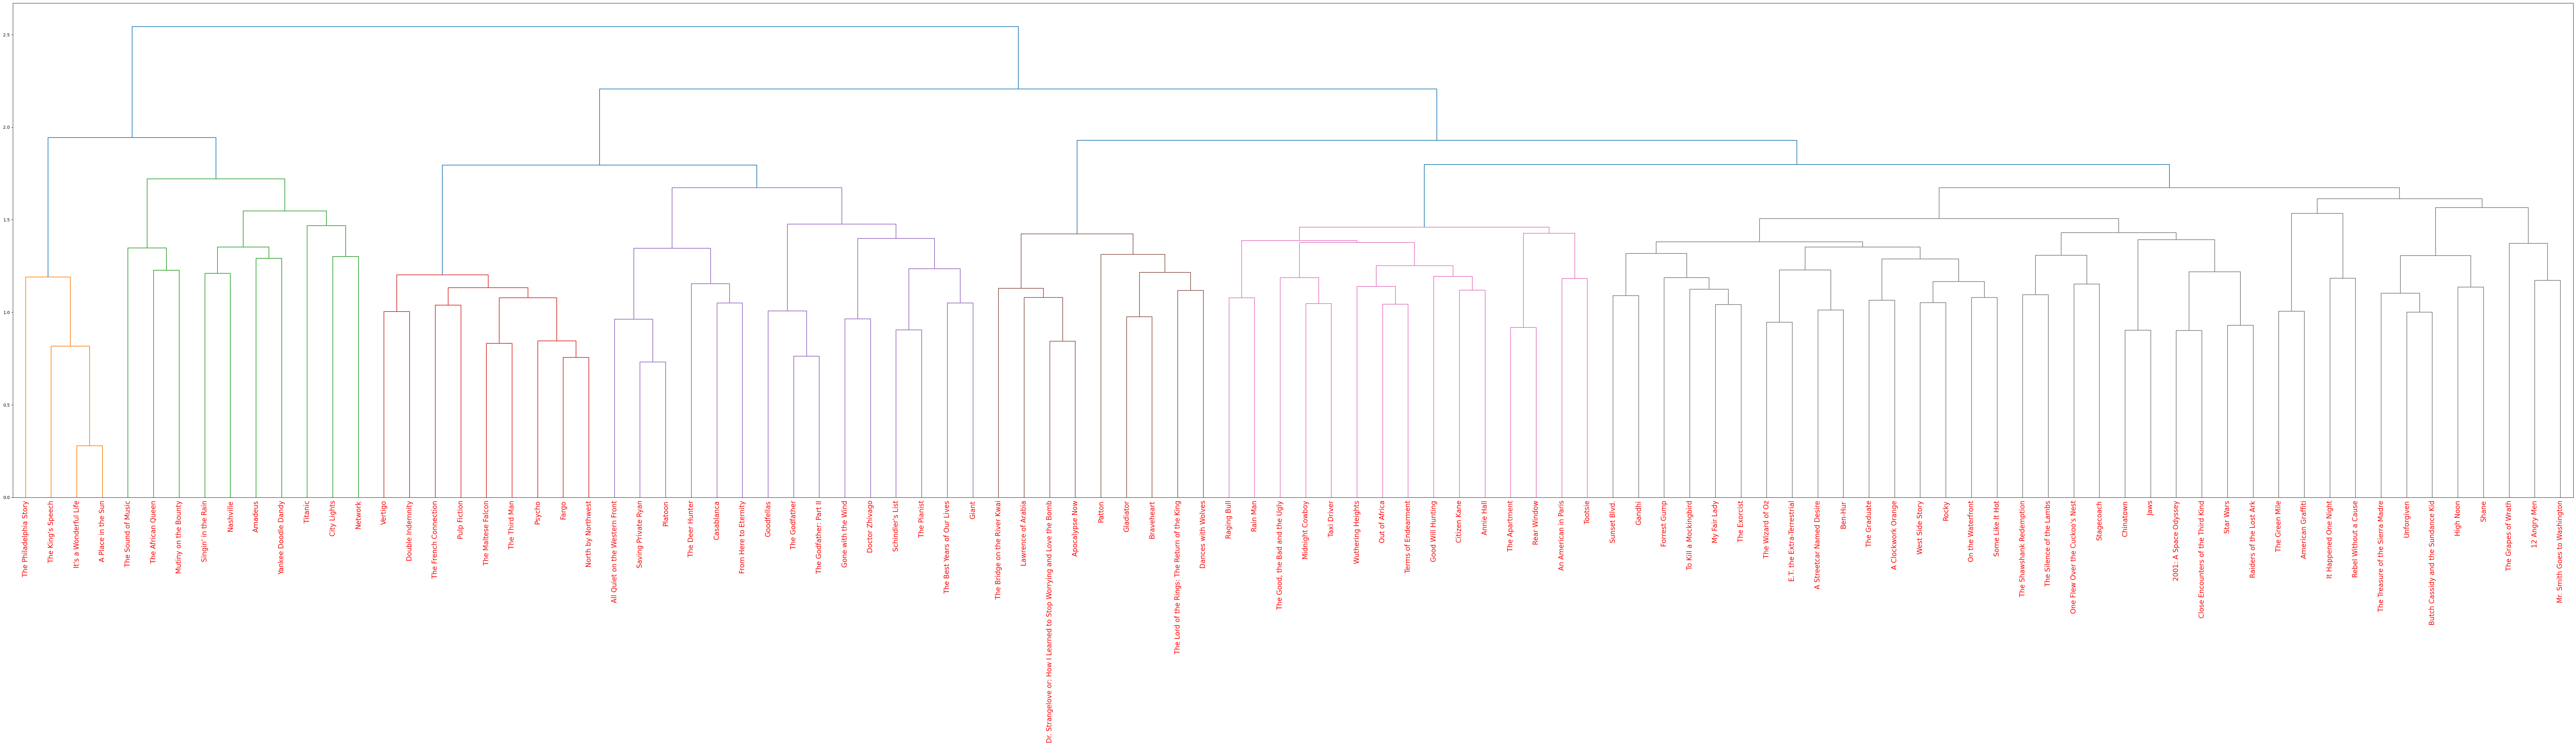

In [59]:
# Create mergings matrix 
mergings = linkage(similarity_distance, method='complete')

# Plot the dendrogram, using title as label column
dendrogram = dendrogram(mergings,
               labels=[x for x in movies_df["title"]],
               leaf_rotation=90,
               leaf_font_size=16,
)


fig = plt.gcf()
_ = [lbl.set_color('r') for lbl in plt.gca().get_xmajorticklabels()]
fig.set_size_inches(108, 21)

# Show dendrogram
plt.show()